In [ ]:
import cv2
import matplotlib.pylab as plt

plt.style.use('classic')            # --①컬러 스타일을 1.x 스타일로 사용
img = cv2.imread('../data/img/mountain.jpg')

plt.subplot(131)
hist = cv2.calcHist([img], [0,1], None, [32,32], [0,256,0,256]) #--②
p = plt.imshow(hist)                                            #--③
plt.title('Blue and Green')                                     #--④
plt.colorbar(p)                                                 #--⑤


plt.subplot(132)
hist = cv2.calcHist([img], [1,2], None, [32,32], [0,256,0,256]) #--⑥
p = plt.imshow(hist)
plt.title('Green and Red')
plt.colorbar(p)

plt.subplot(133)
hist = cv2.calcHist([img], [0,2], None, [32,32], [0,256,0,256]) #--⑦
p = plt.imshow(hist)
plt.title('Blue and Red')
plt.colorbar(p)

plt.show()


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

win_name = 'back_projection'
img = cv2.imread('../data/img/syracuse-635532_640.jpg')
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
draw = img.copy()

#--⑤ 역투영된 결과를 마스킹해서 결과를 출력하는 공통함수
def masking(bp, win_name):
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    cv2.filter2D(bp,-1,disc,bp)
    _, mask = cv2.threshold(bp, 1, 255, cv2.THRESH_BINARY)
    result = cv2.bitwise_and(img, img, mask=mask)
    cv2.imshow(win_name, result)

#--⑥ 직접 구현한 역투영 함수
def backProject_manual(hist_roi):
    #--⑦ 전체 영상에 대한 H,S 히스토그램 계산
    hist_img = cv2.calcHist([hsv_img], [0,1], None,[180,256], [0,180,0,256])
    #--⑧ 선택영역과 전체 영상에 대한 히스토그램 그램 비율계산
    hist_rate = hist_roi/ (hist_img + 1)
    #--⑨ 비율에 맞는 픽셀 값 매핑
    h,s,v = cv2.split(hsv_img)
    bp = hist_rate[h.ravel(), s.ravel()]

    bp = np.minimum(bp, 1)
    bp = bp.reshape(hsv_img.shape[:2])
    cv2.normalize(bp,bp, 0, 255, cv2.NORM_MINMAX)
    bp = bp.astype(np.uint8)
    #--⑩ 역 투영 결과로 마스킹해서 결과 출력
    masking(bp,'result_manual')
 
# OpenCV API로 구현한 함수 ---⑪ 
def backProject_cv(hist_roi):
    # 역투영 함수 호출 ---⑫
    bp = cv2.calcBackProject([hsv_img], [0, 1], hist_roi,  [0, 180, 0, 256], 1)
    # 역 투영 결과로 마스킹해서 결과 출력 ---⑬ 
    masking(bp,'result_cv')

# ROI 선택 ---①
(x,y,w,h) = cv2.selectROI(win_name, img, False)
if w > 0 and h > 0:
    #roi = draw[y:y+h, x:x+w]
    roi = img[y:y+h, x:x+w]
    cv2.rectangle(draw, (x, y), (x+w, y+h), (0,0,255), 2)
    #--② 선택한 ROI를 HSV 컬러 스페이스로 변경
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    #--③ H,S 채널에 대한 히스토그램 계산
    hist_roi = cv2.calcHist([hsv_roi],[0, 1], None, [180, 256], [0, 180, 0, 256] )
    #--④ ROI의 히스토그램을 매뉴얼 구현함수와 OpenCV 이용하는 함수에 각각 전달
    backProject_manual(hist_roi)
    backProject_cv(hist_roi)
cv2.imshow(win_name, draw)
cv2.waitKey()
cv2.destroyAllWindows()

CORREL    	img1:   1.00	img2:   0.70	img3:   0.56	img4:   0.23	
CHISQR    	img1:   0.00	img2:  67.33	img3:  35.71	img4:1129.49	
INTERSECT 	img1:   1.00	img2:   0.54	img3:   0.40	img4:   0.18	
BHATTACHARYYA	img1:   0.00	img2:   0.48	img3:   0.47	img4:   0.79	


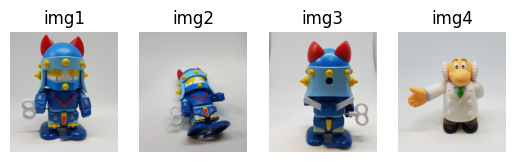

: 

In [ ]:
import cv2, numpy as np
import matplotlib.pylab as plt

img1 = cv2.imread('../data/img/taekwonv1.jpg')
img2 = cv2.imread('../data/img/taekwonv2.jpg')
img3 = cv2.imread('../data/img/taekwonv3.jpg')
img4 = cv2.imread('../data/img/dr_ochanomizu.jpg')


imgs = [img1, img2, img3, img4]
hists = []
for i, img in enumerate(imgs) :
    plt.subplot(1,len(imgs),i+1)
    plt.title('img%d'% (i+1))
    plt.axis('off') 
    plt.imshow(img[:,:,::-1])
    #---① 각 이미지를 HSV로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #---② H,S 채널에 대한 히스토그램 계산
    hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
    #---③ 0~1로 정규화
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    hists.append(hist)


query = hists[0]
methods = {'CORREL' :cv2.HISTCMP_CORREL, 'CHISQR':cv2.HISTCMP_CHISQR, 
           'INTERSECT':cv2.HISTCMP_INTERSECT,
           'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}
for j, (name, flag) in enumerate(methods.items()):
    print('%-10s'%name, end='\t')
    for i, (hist, img) in enumerate(zip(hists, imgs)):
        #---④ 각 메서드에 따라 img1과 각 이미지의 히스토그램 비교
        ret = cv2.compareHist(query, hist, flag)
        if flag == cv2.HISTCMP_INTERSECT: #교차 분석인 경우 
            ret = ret/np.sum(query)        #비교대상으로 나누어 1로 정규화
        print("img%d:%7.2f"% (i+1 , ret), end='\t')
    print()
plt.show()
cv2.imshow('query', img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
import cv2
import numpy as np

# 영상의 15%를 알파 블렌딩의 범위로 지정
alpha_width_rate = 15

# 합성할 두 영상 읽기
img_face = cv2.imread('../data/img/man_face.jpg')
img_skull = cv2.imread('../data/img/skull.jpg')

# 입력 영상과 같은 크기의 결과 영상 준비
img_comp = np.zeros_like(img_face)

# 연산에 필요한 좌표 계산
height, width = img_face.shape[:2]
middle = width//2                             # 영상의 중앙 좌표
alpha_width = width * alpha_width_rate // 100 # 알파 블렌딩 범위
start = middle - alpha_width//2               # 알파 블렌딩 시작 지점
step = 100/alpha_width                        # 알파 값 간격

# 입력 영상의 절반씩 복사해서 결과 영상에 합성
img_comp[:, :middle, : ] = img_face[:, :middle, :].copy()
img_comp[:, middle:, :] = img_skull[:, middle:, :].copy()
cv2.imshow('half', img_comp)

# 알파 값을 바꾸면서 알파 블렌딩 적용
for i in range(alpha_width+1 ):
    alpha = (100 - step * i) / 100  # 증감 간격에 따른 알파 값 (1~0)
    beta = 1 - alpha                # 베타 값 (0~1)
    # 알파 블렌딩 적용
    img_comp[:, start+i] = img_face[:, start+i] * \
                                alpha + img_skull[:, start+i] * beta
    print(i, alpha, beta)
    
cv2.imshow('half skull', img_comp)
cv2.waitKey()
cv2.destroyAllWindows()

0 1.0 0.0
1 0.9895833333333333 0.01041666666666674
2 0.9791666666666667 0.02083333333333326
3 0.96875 0.03125
4 0.9583333333333333 0.04166666666666674
5 0.9479166666666667 0.05208333333333326
6 0.9375 0.0625
7 0.9270833333333333 0.07291666666666674
8 0.9166666666666667 0.08333333333333326
9 0.90625 0.09375
10 0.8958333333333333 0.10416666666666674
11 0.8854166666666667 0.11458333333333326
12 0.875 0.125
13 0.8645833333333333 0.13541666666666674
14 0.8541666666666667 0.14583333333333326
15 0.84375 0.15625
16 0.8333333333333333 0.16666666666666674
17 0.8229166666666665 0.17708333333333348
18 0.8125 0.1875
19 0.8020833333333333 0.19791666666666674
20 0.7916666666666665 0.20833333333333348
21 0.78125 0.21875
22 0.7708333333333333 0.22916666666666674
23 0.7604166666666665 0.23958333333333348
24 0.75 0.25
25 0.7395833333333333 0.26041666666666674
26 0.7291666666666665 0.2708333333333335
27 0.71875 0.28125
28 0.7083333333333333 0.29166666666666674
29 0.6979166666666665 0.3020833333333335
30 0

In [1]:
import cv2
import numpy as np

# 감도 설정(카메라 품질에 따라 조정 필요)
thresh = 25    # 달라진 픽셀 값 기준치 설정
max_diff = 5   # 달라진 픽셀 갯수 기준치 설정

# 카메라 캡션 장치 준비
a, b, c = None, None, None
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 480)      # 프레임 폭을 480으로 설정 
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 320)     # 프레임 높이를 320으로 설정

if cap.isOpened():
    ret, a = cap.read()         # a 프레임 읽기
    ret, b = cap.read()         # b 프레임 읽기

    while ret:
        ret, c = cap.read()     # c 프레임 읽기
        draw = c.copy()         # 출력 영상에 사용할 복제본
        if not ret:
            break
        
        # 3개의 영상을 그레이 스케일로 변경
        a_gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
        b_gray = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        c_gray = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)

        # a-b, b-c 절대 값 차 구하기 
        diff1 = cv2.absdiff(a_gray, b_gray)
        diff2 = cv2.absdiff(b_gray, c_gray)

        # 스레시홀드로 기준치 이내의 차이는 무시
        ret, diff1_t = cv2.threshold(diff1, thresh, 255, cv2.THRESH_BINARY)
        ret, diff2_t = cv2.threshold(diff2, thresh, 255, cv2.THRESH_BINARY)

        # 두 차이에 대해서 AND 연산, 두 영상의 차이가 모두 발견된 경우
        diff = cv2.bitwise_and(diff1_t, diff2_t)

        # 열림 연산으로 노이즈 제거 ---①
        k = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, k)

        # 차이가 발생한 픽셀이 갯수 판단 후 사각형 그리기
        diff_cnt = cv2.countNonZero(diff)
        if diff_cnt > max_diff:
            nzero = np.nonzero(diff)  # 0이 아닌 픽셀의 좌표 얻기(y[...], x[...])
            cv2.rectangle(draw, (min(nzero[1]), min(nzero[0])), \
                                (max(nzero[1]), max(nzero[0])), (0,255,0), 2)
            cv2.putText(draw, "Motion Detected", (10,30), \
                                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255))
        
        # 컬러 스케일 영상과 스레시홀드 영상을 통합해서 출력
        stacked = np.hstack((draw, cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)))
        cv2.imshow('motion sensor',stacked )

        # 다음 비교를 위해 영상 순서 정리
        a = b
        b = c
        
        if cv2.waitKey(1) & 0xFF == 27:
            break                